# Load and Perturbe Image

In [1]:
from __future__ import print_function, division
import cv2
import torch
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
results_dir = 'results/'
example_name = "toyexample_6"

In [2]:
%load_ext autoreload
%autoreload 2

from featureBA.src.model_philipp import sparse3DBA
from featureBA.src.utils import sobel_filter

In [3]:
toy_pickle_path = "toy_example/data/%s_data.p" % example_name
toy_image_path = "toy_example/data/%s.png" % example_name

In [4]:
data = pickle.load(open(toy_pickle_path, 'rb'))
img = cv2.imread(toy_image_path)

In [5]:
#Create a 10° rotated (around z-axis) calibrated projection matrix (relative to identity)
T_perturbed = np.array([[math.cos(10*math.pi/180), -math.sin(10*math.pi/180), 0, 0],
             [math.sin(10*math.pi/180), math.cos(10*math.pi/180), 0, 0],
             [0, 0, 1, 0]])

In [6]:
data['coords'] = np.around(data['2d_points']).astype(int) - 1

In [7]:
# Camera matrix
P_perturbed = np.dot(data['K'], T_perturbed)

# Project 3D points with this new perturbed camera matrix: np.array Nx2
projected_2d = np.dot(P_perturbed, np.concatenate((data['3d_points'], np.ones(len(data['3d_points']))[:, None]),-1).T)
projected_2d = (projected_2d.T/projected_2d.T[:,2,None])[:, :2]

In [8]:
# Round double coords to ints -> to use as index in matrix
coords_2d = np.around(projected_2d)
coords_2d = coords_2d.astype(int) - 1

In [9]:
# Draw perturbed points into original image
img = img.astype('uint8')
for i, p in enumerate(coords_2d):
    print(i, p)
    cv2.circle(img, tuple(p), 4, (128, 128, 0), -1)

0 [459 824]
1 [743 513]
2 [329 168]
3 [873 719]
4 [121 783]
5 [576 335]
6 [419  82]
7 [398 853]
8 [ -6 723]
9 [757 317]
10 [855 498]
11 [408 666]
12 [204 285]
13 [189 260]


True

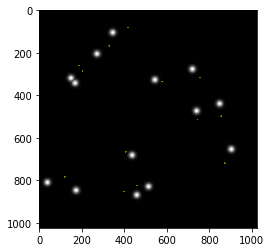

In [10]:
# Show image with perturbed points + Write
plt.imshow(img)
cv2.imwrite(results_dir + example_name + '_perturbed_points.png', img)

# Feature BA

In [11]:
from featureBA.src.model_philipp import optimizer_step, indexing_

from featureBA.src.utils import (from_homogeneous, to_homogeneous,
                batched_eye_like, skew_symmetric, so3exp_map)

from featureBA.src.utils import squared_loss, scaled_loss

In [12]:
# Reload image as doubles
data = pickle.load(open(toy_pickle_path, 'rb'))
img = cv2.imread(toy_image_path,0)
img = img.astype('double')

In [13]:
# Create image tensor
img_torch = torch.from_numpy(img)[None,...]

# Convolve Sobel Filter to extract x and y gradient: 1xHxW
grad_x, grad_y = sobel_filter(img_torch)

In [14]:
%%capture
# Exemplary, Show perturbed points on the y-gradient of the image. Resized to 128x128
"""
grad_y_img = grad_y.numpy().reshape(img.shape).astype('uint8')
for i, p in enumerate(coords_2d):
    print(i, p)
    cv2.circle(grad_y_img, tuple(p), 1, (128, 128, 0), -1)
plt.imshow(grad_y_img)
cv2.imwrite(results_dir+example_name + "_grad_x.png", grad_x.numpy().reshape(img.shape).astype('uint8'))
cv2.imwrite(results_dir+example_name + "_grad_y.png", grad_y.numpy().reshape(img.shape).astype('uint8'))
"""

In [15]:
#Create a 10° rotated (around z-axis) calibrated projection matrix (relative to identity)

angle = 4

offset_x = 0
offset_y = 0
offset_z = -0.1
T_perturbed = np.array([[math.cos(angle*math.pi/180), -math.sin(angle*math.pi/180), 0,offset_x],
             [math.sin(angle*math.pi/180), math.cos(angle*math.pi/180), 0, offset_y],
             [0, 0, 1, offset_z]])
print(T_perturbed)

[[ 0.99756405 -0.06975647  0.          0.        ]
 [ 0.06975647  0.99756405  0.          0.        ]
 [ 0.          0.          1.         -0.1       ]]


In [16]:
data['coords'] = np.around(data['2d_points']).astype(int) - 1

In [17]:
# Camera matrix
P_perturbed = np.dot(data['K'], T_perturbed)

# Project 3D points with this new perturbed camera matrix: np.array Nx2
projected_2d = np.dot(P_perturbed, np.concatenate((data['3d_points'], np.ones(len(data['3d_points']))[:, None]),-1).T)
projected_2d = (projected_2d.T/projected_2d.T[:,2,None])[:, :2]

In [18]:
# Load 3D Points
pts3D = torch.from_numpy(data['3d_points'][:,:3])
# Load 2D Points in reference image: [[x1,y1], ....]
ref2d = torch.from_numpy(np.flip(data['coords'], axis = 1).copy())
# 2D Tensor with intensity at reference feature pixel (= center of gaussian = 255)-> [[255],[255], ...] NFx1
feature_ref = torch.cat([img_torch[:, i, j].unsqueeze(0) for i, j in zip(ref2d[:,0], ref2d[:,1])]).type(torch.DoubleTensor)
feature_map_query = img_torch.type(torch.DoubleTensor)

#Load initial rotation and translation for query image (=perturbed image)
R_init, t_init = torch.from_numpy(T_perturbed[:, :3]), torch.from_numpy(T_perturbed[:, 3])
feature_grad_x = grad_x
feature_grad_y = grad_y

# Camera intrinsics tensor 3x3
K = torch.from_numpy(data['K'])

In [19]:
# Set runtime parameters
n_iters = 50
lambda_ = 0.01 # regularization
verbose=False

In [20]:
# Load actual model
model = sparse3DBA(n_iters = n_iters, lambda_ = lambda_, verbose=verbose)

In [21]:
# Run the model -> this calls the forward method of model
R, t = model(pts3D, feature_ref, feature_map_query, feature_grad_x, feature_grad_y, K, R_init, t_init, track = True)

cost increased, continue with next iteration
cost increased, continue with next iteration


In [22]:
cost_list = model.track_["costs"]
point_list = torch.stack(model.track_["points2d"])

# Visualization

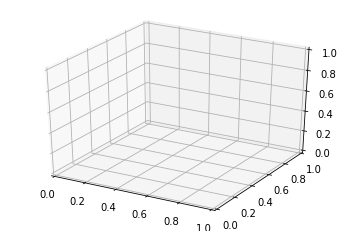

In [23]:
import visualization.plot_3d_tools as plot_3d

In [24]:
# get final cost to see if visualization makes sense (Should be really low)
print(cost_list[0])
print(cost_list[-1])
print(R)
print(t)

27632.846153846152
1.4285714285714286
tensor([[ 1.0000e+00, -1.8926e-03,  2.9222e-04],
        [ 1.8926e-03,  1.0000e+00,  1.1686e-05],
        [-2.9224e-04, -1.1133e-05,  1.0000e+00]], dtype=torch.float64)
tensor([-0.0310, -0.0465, -0.0072], dtype=torch.float64)


In [25]:
%%capture
# Create a list of images, size Hx2*W
# Takes some time (~ half a minute with n_iters=100 and image size 1024x1024)
# Change DPI and draw parameters(radius, thickness) as you like
my_dpi = 160 #For plotting, change this as you like, 160 works good for 1024x1024

# Create base-image im RGB
rgb_img = cv2.cvtColor(img.astype('uint8').copy(),cv2.COLOR_GRAY2RGB)
height, width, layers = rgb_img.shape

# Set of 2D points: n_iters+1 x N x 2
pts = np.array(point_list,dtype=np.int32)
img_list=[]
for i in range(n_iters +1):
    # Create a copy of base image to work on
    img_int = rgb_img.copy()
    
    label = "Cost: %f" % cost_list[i]
    
    # Create cost plot (you can add any measure vs. iteration you like here, e.g. the error of a specific feature)
    fig, ax= plt.subplots(1,1,figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
    ax.plot(range(i+1),np.array(cost_list[:i+1]), color = "red")
    ax.set_xlim([0,n_iters+1])
    ax.set_title("Cost vs. Iterations")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Cost (mean)")
    ax.set_ylim([0,max(cost_list)*1.1])
    # Convert image to an array so we can concatenate with our image
    fig_data = plot_3d.fig2data(fig)
    
    # For every 2D point in our image
    for j, p in enumerate(coords_2d):
        # Draw past line
        cv2.polylines(img_int, np.int32([pts[:i+1,j,:]]), False, (0,0,255), 1)
        # Draw start point
        cv2.circle(img_int, tuple(pts[0,j,:]), 4, (0,255,0), -1) 
        # Draw current point
        cv2.circle(img_int, tuple(pts[i,j,:]), 4, (0,0,255), -1) 
        # Draw Label
        cv2.putText(img_int, label, (20,20), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 2)
    
    # Append image list
    img_list.append(np.concatenate((img_int,fig_data), axis=1))

In [26]:
# Create video out of image list
height, width, layers = img_list[0].shape
video= cv2.VideoWriter(results_dir + example_name + "_video.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 5, (width,height))
for image in img_list:
    video.write(image)
video.release()

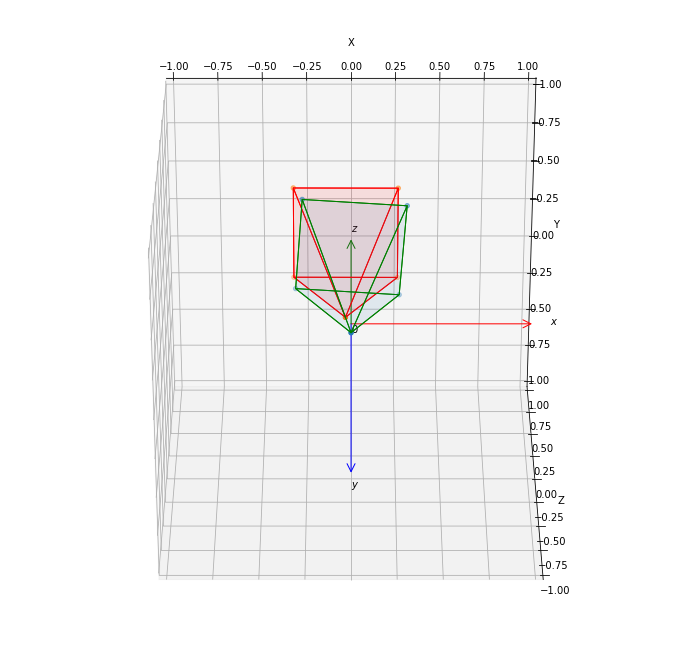

In [27]:
# Visualize camera pose  in 3D (example)


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# Draw Coordinate frame
plot_3d.plot_coordinate_system(ax)

# Plot initial camera pose (green pyramid)
plot_3d.plot_camera(ax,R_init.numpy(),t_init.numpy(), edgecolor="g", facecolor=None, alph=0.05)

# Plot final camera pose (red pyramid)
plot_3d.plot_camera(ax,R.numpy(),t.numpy(), edgecolor="r", facecolor="r", alph=0.05)

# Adjust Angle of 3D plot view
ax.view_init(elev=-60, azim=-90)

# ToDo: Scatter the 3D points in this plot

# Show Plot
plt.show()

In [28]:
new_proj_1

NameError: name 'new_proj_1' is not defined

In [ ]:
width, height = (600,600)
pad = 1
mask = (new_proj_1[:,0] >= pad) & (new_proj_1[:,1] >= pad) & (new_proj_1[:,0] < width - pad) & (new_proj_1[:,1] < height - pad)

In [ ]:
new_proj_1[mask,:]
